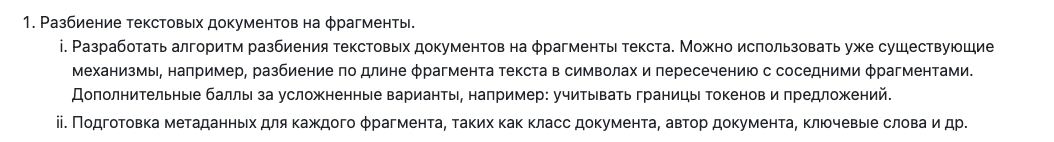

In [ ]:
import re
import os
from tqdm import tqdm

In [ ]:
def split_into_fragments(text, fragment_length=100):
    fragments = [text[i:i+fragment_length] for i in range(0, len(text), fragment_length)]
    return fragments

In [ ]:
def find_author(text):
    match = re.search(r'From:(.*?)(?=\w+:|$)', text, re.DOTALL)
    if match:
        result = match.group(1).strip()
        return result
    else:
        return None

In [ ]:
def processing_dataset(dataset_path, len = 100):
    all_fragments = list()
    all_metadate = list()
    catalogs = os.listdir(dataset_path)
    for catalog in tqdm(catalogs):
        path_catalog = os.path.join(f'{dataset_path}/{catalog}')
        files = os.listdir(path_catalog)
        for file in files:
            file_path = os.path.join(f'{path_catalog}/{file}')
            with open(file_path, 'r', encoding='latin1') as file_name:
                sample_content = file_name.read()
                cleaned_text = sample_content.replace('\t', ' ').replace('\n', ' ')
                cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
                fragments = split_into_fragments(cleaned_text)
                author = find_author(sample_content)
                count = 0
                for fragment in fragments:
                    meta_fragment = {'class': path_catalog.split('/')[-1],
                                     'doc_fragment': f'{file}-{count}',
                                     'author': author}
                    all_metadate.append(meta_fragment)
                    all_fragments.append(fragment)
                    count += 1
    return all_fragments, all_metadate

In [ ]:
data_path = '/media/space/ssd_1_tb_evo_sumsung/MishaHW/20news-bydate-train'
all_fragments, all_metadate = processing_dataset(data_path)

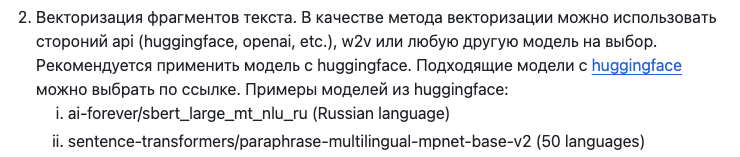

In [ ]:
from sentence_transformers import SentenceTransformer

class Embedder():
    def __init__(self):
        self.model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
    
    def __call__(self, input):
        input = self.model.encode(input).tolist()
        return input
    
embedder = Embedder()
#embeddings = embedder.get_embeding(all_fragments)

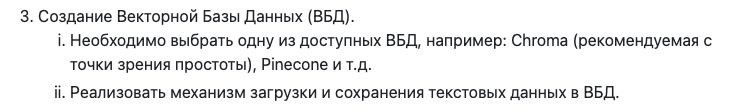

In [ ]:
import chromadb
from sentence_transformers import SentenceTransformer



class ChromaDB():
    def __init__(self):
        self.embedding_model = Embedder()
        self.client = chromadb.PersistentClient(path='/media/space/ssd_1_tb_evo_sumsung/MishaHW/ChromaDB')
        self.collection = self.client.get_or_create_collection(name="coll", embedding_function=self.embedding_model)

    def add_collection(self, all_fragments, all_metadate):
        o_b = 0
        b = 20000
        ids = [str(i) for i in range(len(all_metadate))]
        while True:
            if b > len(all_fragments):
                break
            else:
                self.collection.add(
                    documents = all_fragments[o_b:b],
                    embeddings = self.embedding_model(all_fragments[o_b:b]),
                    metadatas = all_metadate[o_b:b],
                    ids=ids[o_b:b]
                )
                o_b = b
                b += 20000

        self.collection.add(
                    documents = all_fragments[o_b:b],
                    embeddings = self.embedding_model(all_fragments[o_b:]),
                    metadatas = all_metadate[o_b:],
                    ids=ids[o_b:]
                )
        print("Data was loaded")

    def search(self, text, count = 1):
        vector = self.embedding_model(text)
        result = self.collection.query(
            query_embeddings = vector,
            n_results = count,
            include=['distances','embeddings', 'documents', 'metadatas'],
        )
        return result
        

In [ ]:
cdb = ChromaDB()

In [ ]:
cdb.add_collection(all_fragments, all_metadate)

In [ ]:
questions = [
    ['How old are you?', 2],
    ['What is your favorite color?', 3],
    ['Where were you born?', 1],
    ['Do you have any siblings?', 2],
    ['What is your favorite movie?', 3],
    ['If you could travel anywhere, where would you go?', 1],
    ['What is your favorite book?', 2],
    ['What is your dream job?', 3],
    ['Do you play any musical instruments?', 1],
    ['What is your favorite food?', 2]
]
count = 0
for question in questions:
    result = cdb.search(question[0], question[1])
    print(f"-----------Вопрос №{count}-----------")
    print(f"Вопрос: {question[0]}")
    print(f"Ответы: {result['documents']}")
    print()
    count +=1